# Results Atlas-based Registration
In this notebook, the results of the atlas-based registration are visualized. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from statannotations.Annotator import Annotator
from scipy import stats

## Total result over all folds
First, the mean and standard deviation pver all folds for every experiment is shown. The highest mean dice coefficient of 0.858 $\pm$ 0.056 is obtained with the `Normalization` experiment. The lowest mean dice coefficient of 0.741 $\pm$ 0.266 is obtained with the `Prostate only` experiment. Furthermore, the standard deviation of the `Prostate only` experiment is the highest due to two outliers.

In [2]:
# Read the results into pandas
df_results = pd.read_excel("results_registration.xlsx").set_index("image_number")

# Show mean and standard deviation
df_results.drop(columns="fold_number").agg(["mean", "std"])

,Baseline,Normalisation,Elastic,Affine,Gamma,Prostate only
mean,0.856293,0.857933,0.854553,0.856533,0.832260,0.741247
std,0.056541,0.055640,0.050451,0.054263,0.066708,0.266345


We can test if the experiments are likely distributed as a Gaussian distribution by performing a Shapiro-Wilk test. For each experiment, the p-value is determined along with a histogram showing the data distribution and a Quartile-Quartile plot. For most experiments, the data seems to be approximated by a Gaussian distribution when looking at the p-values and the points in the QQ-plot. However, the `Prostate only` experiment is clearly not Gaussian, which is probably caused by the outliers in the results.

Baseline experiment is likely normally distributed (fail to reject H0).
p-value = 0.213
------
Normalisation experiment is likely normally distributed (fail to reject H0).
p-value = 0.340
------
Elastic experiment is likely normally distributed (fail to reject H0).
p-value = 0.484
------
Affine experiment is likely normally distributed (fail to reject H0).
p-value = 0.153
------
Gamma experiment is likely normally distributed (fail to reject H0).
p-value = 0.090
------
Prostate only experiment is NOT normally distributed (reject H0).
p-value = 0.000
------


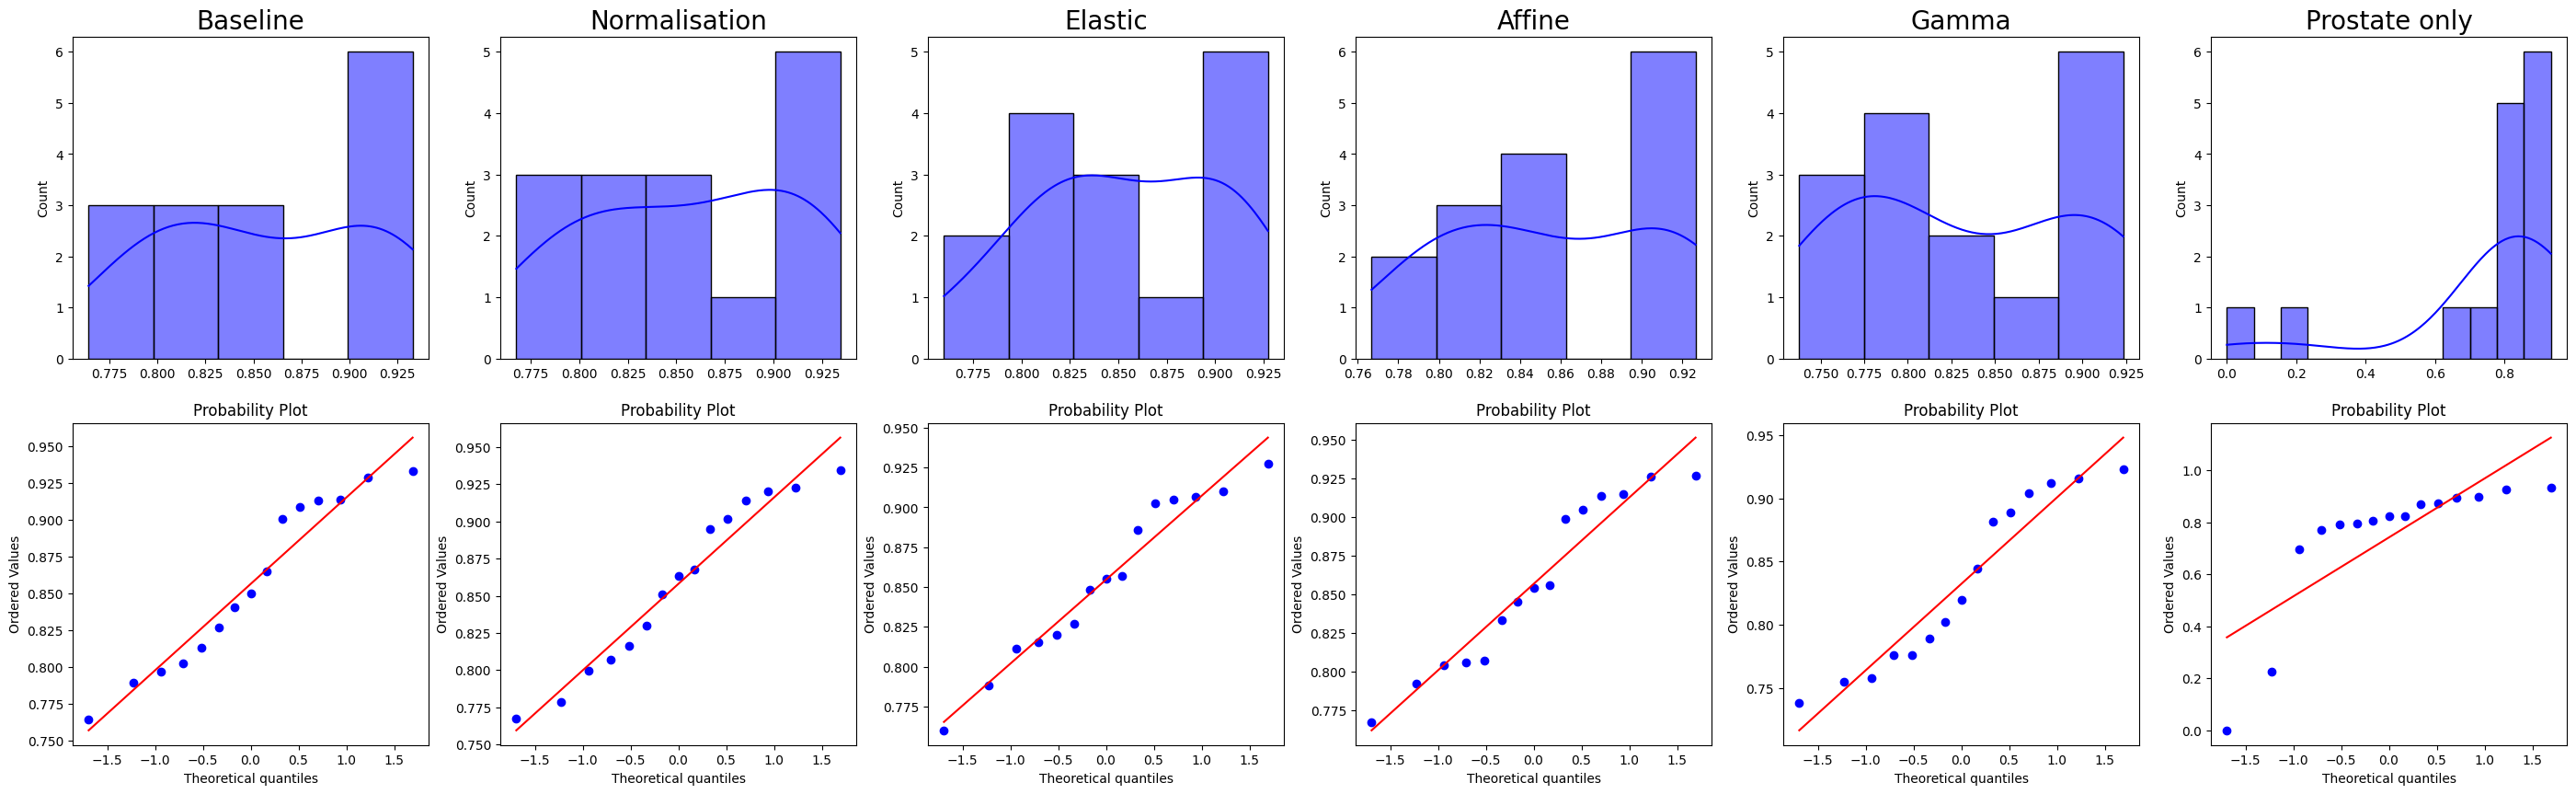

In [3]:
# List of experiments
experiments = list(df_results.columns[1:])

# Check for normality of dice scores
alpha = 0.05
fig, ax = plt.subplots(2, 6, figsize=(35, 10))
for idx in range(len(experiments)):
    # Plot histogram
    results_exp = list(df_results[experiments[idx]])
    sns.histplot(results_exp, kde=True, color="Blue", ax=ax[0,idx])
    stats.probplot(results_exp, dist="norm", plot=ax[1,idx])
    ax[0,idx].set_title(experiments[idx], fontsize=20)

    # Compute Shapiro-Wilk test
    stat, pval = stats.shapiro(results_exp)
    if pval > alpha:
        print(f"{experiments[idx]} experiment is likely normally distributed (fail to reject H0).")
        print(f"p-value = {pval:.3f}")
        print("------")
    else:
        print(f"{experiments[idx]} experiment is NOT normally distributed (reject H0).")
        print(f"p-value = {pval:.3f}")
        print("------")

Assuming that the dice coefficients of almost all experiments are normally distributed, we can now perform a statistical test to see if the experiments are significantly better than the `Baseline` experiment. A paired t-test is used to evaluate if the mean dice of the experiments is greater than the mean dice of the `Baseline` experiment.

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Baseline vs. Normalisation: p = 0.27
Baseline vs. Elastic: p = 0.71
Baseline vs. Affine: p = 0.46
Baseline vs. Gamma: p = 1.0


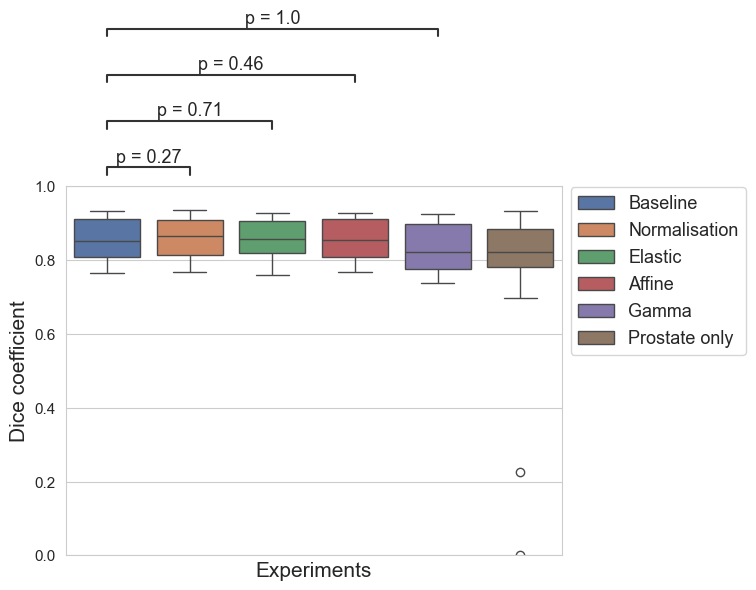

In [4]:
# Isolate results of baseline experiment
results_baseline = list(df_results["Baseline"])

# Compute p-values of all experiments compared to baseline
p_values = []
for exp in experiments[1:-1]:
    results_exp = list(df_results[exp])
    stat, pval = stats.ttest_rel(results_exp, results_baseline, alternative="greater")
    p_values.append(pval)
    
# Create boxplot
df_boxplot = df_results.drop(columns="fold_number")
sns.set_style("whitegrid")
ax = sns.boxplot(data=df_boxplot, palette="deep")  
ax.set_xlabel("Experiments", fontsize=15)
ax.set_ylabel("Dice coefficient", fontsize=15)
ax.legend(experiments, loc='upper left', bbox_to_anchor=(1, 1.02), fontsize=13)
ax.tick_params(labelsize=11)
ax.set_xticks([])
ax.set_ylim([0, 1])

# Add statistical annotation
pairs = [
    ("Baseline", "Normalisation"),
    ("Baseline", "Elastic"),
    ("Baseline", "Affine"),
    ("Baseline", "Gamma")
]
annotator = Annotator(ax, pairs, data=df_boxplot)
annotator.configure(loc="outside", fontsize=13)
annotator.set_custom_annotations([f"p = {p:.2}" for p in p_values])
annotator.annotate()

# Print total statistics
df_results.drop(columns="fold_number").agg(["mean", "std"]);

## Results per fold
It is also interesting to compare the three folds with each other per experiment to see if there are large differences based on the subset of atlas images used to determine the segmentation. `Fold 2` achieves the highest mean dice and `Fold 1` the lowest mean dice in all individual experiments.

In [5]:
# Show mean and standard deviation
df_results.groupby("fold_number").agg(["mean", "std"])

Baseline           Normalisation            Elastic            \
                mean       std          mean       std     mean       std   
fold_number                                                                 
Fold 1       0.83844  0.038803       0.83670  0.044492  0.84396  0.038259   
Fold 2       0.87842  0.057388       0.88186  0.055867  0.87574  0.044389   
Fold 3       0.85202  0.073189       0.85524  0.066681  0.84396  0.068064   

              Affine              Gamma           Prostate only            
                mean       std     mean       std          mean       std  
fold_number                                                                
Fold 1       0.83694  0.041942  0.80728  0.060780       0.66534  0.376485  
Fold 2       0.87934  0.051848  0.86098  0.061307       0.83446  0.047543  
Fold 3       0.85332  0.068668  0.82852  0.079331       0.72394  0.293000

Each fold has a very small sample size of n=5 so any statistical testing is probably not very accurate. Assuming the dice coefficients are not normally distributed, a Wilcoxon test is performed to see what the outcome is. With such a small sample size, it is probably better to just mention the mean and standard deviation.

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Normalisation_Fold 1 vs. Normalisation_Fold 2: p = 0.19
Normalisation_Fold 2 vs. Normalisation_Fold 3: p = 0.62
Elastic_Fold 1 vs. Elastic_Fold 2: p = 0.44
Elastic_Fold 2 vs. Elastic_Fold 3: p = 0.62
Affine_Fold 1 vs. Affine_Fold 2: p = 0.31
Affine_Fold 2 vs. Affine_Fold 3: p = 0.62
Gamma_Fold 1 vs. Gamma_Fold 2: p = 0.19
Gamma_Fold 2 vs. Gamma_Fold 3: p = 0.62
Prostate only_Fold 1 vs. Prostate only_Fold 2: p = 0.81
Prostate only_Fold 2 vs. Prostate only_Fold 3: p = 0.81
Baseline_Fold 1 vs. Baseline_Fold 2: p = 0.31
Baseline_Fold 2 vs. Baseline_Fold 3: p = 0.62
Normalisation_Fold 1 vs. Normalisation_Fold 3: p = 0.31
Elastic_Fold 1 vs. Elastic_Fold 3: p = 1.0
Affine_Fold 1 vs. Affine_Fold 3: p = 0.62
Gamma_Fold 1 vs. Gamma_Fold 3: p = 0.62
Prostate only_Fold 1 vs. Prostate only_Fold 3: p = 0.44
Bas

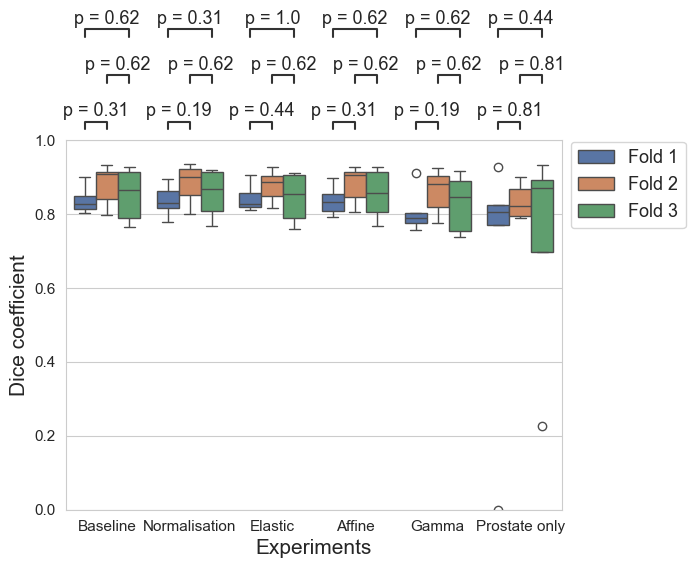

In [6]:
# Melt dataframe into short format
df_melt = df_results.melt(id_vars="fold_number", value_vars=experiments)

# Compute p-values of all experiment pairs
p_values = []
for exp in experiments:
    results_exp_fold_1 = list(df_results[df_results["fold_number"] == "Fold 1"][exp])
    results_exp_fold_2 = list(df_results[df_results["fold_number"] == "Fold 2"][exp])
    results_exp_fold_3 = list(df_results[df_results["fold_number"] == "Fold 3"][exp])

    stat, pval = stats.wilcoxon(results_exp_fold_1, results_exp_fold_2)
    p_values.append(pval)
    stat, pval = stats.wilcoxon(results_exp_fold_2, results_exp_fold_3)
    p_values.append(pval)
    stat, pval = stats.wilcoxon(results_exp_fold_1, results_exp_fold_3)
    p_values.append(pval)

# Create boxplot
ax = sns.boxplot(data=df_melt, x="variable", y="value", hue="fold_number", palette="deep")  
ax.set_xlabel("Experiments", fontsize=15)
ax.set_ylabel("Dice coefficient", fontsize=15)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.02), fontsize=13)
ax.tick_params(labelsize=11)
ax.set_ylim([0, 1])

# Add statistical annotation
pairs = []
for exp in experiments:
    for fold in range(1, 4):
        if fold == 1:
            pairs.append(((exp, "Fold 1"), (exp, "Fold 2")))
        elif fold == 2:
            pairs.append(((exp, "Fold 2"), (exp, "Fold 3")))
        else:
            pairs.append(((exp, "Fold 1"), (exp, "Fold 3")))

annotator = Annotator(ax, pairs, data=df_melt, x="variable", y="value", hue="fold_number")
annotator.configure(loc="outside", fontsize=13)
annotator.set_custom_annotations([f"p = {p:.2}" for p in p_values])
annotator.annotate();